# Autotalker Tutorial

Created by Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [135]:
import argparse
import os
import random
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import scanpy as sc
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.benchmarking import (compute_avg_cad,
                                     compute_cad,
                                     compute_avg_gcd,
                                     compute_max_lnmi,
                                     compute_per_cell_log_rclisi)
from autotalker.data import load_spatial_adata_from_csv
from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_omnipath_lr_interactions)

In [7]:
# Define default matplotlib figure size
matplotlib.rcParams['figure.figsize'] = (20, 10)

# 1.2 Configure Paths and Create Directories

In [8]:
# Mlflow
os.makedirs("mlruns", exist_ok=True)

# Gene program data
gp_data_folder_path = "datasets/gp_data"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"
os.makedirs(gp_data_folder_path, exist_ok=True)

### 1.3 Define Parameters

In [9]:
random_state = 42
dataset = "squidpy_seqfish"
radius = 0.05 # 30.0 for slideseqv2
# node_label_method = "self"
# node_label_method = "one-hop-sum"
node_label_method = "one-hop-norm"
# node_label_method = "one-hop-attention"
n_latent_fc_gps = 512
edge_batch_size = 32 # training did not work when too small

In [142]:
random.seed(42)

## 2. Data

### 2.1 Load Data

In [10]:
print(f"Using dataset {dataset}.")

if dataset == "deeplinc_seqfish":
    adata = load_spatial_adata_from_csv(counts_file_path="datasets/seqFISH/counts.csv",
                                        adj_file_path="datasets/seqFISH/adj.csv",
                                        cell_type_file_path="datasets/seqFISH/cell_types.csv",
                                        cell_type_col="Cell_class_name")
    cell_type_key = "cell_type"
elif dataset == "squidpy_seqfish":
    adata = sq.datasets.seqfish()
    sq.gr.spatial_neighbors(adata, radius=radius, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"
elif dataset == "squidpy_slideseqv2":
    adata = sq.datasets.slideseqv2()
    sq.gr.spatial_neighbors(adata, radius=radius, coord_type="generic")
    cell_type_key = "cluster"
    
adata.layers["counts"] = adata.X.copy()

Using dataset squidpy_seqfish.


In [11]:
print(f"Number of nodes: {adata.layers['counts'].shape[0]}")
print(f"Number of node features: {adata.layers['counts'].shape[1]}")
avg_edges_per_node = round(
    adata.obsp['spatial_connectivities'].toarray().sum(axis=0).mean(),2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(np.triu(adata.obsp['spatial_connectivities'].toarray()).sum())
print(f"Number of edges: {n_edges}", sep="")

Number of nodes: 19416
Number of node features: 351
Average number of edges per node: 7.66
Number of edges: 74329


### 2.2 Explore Data

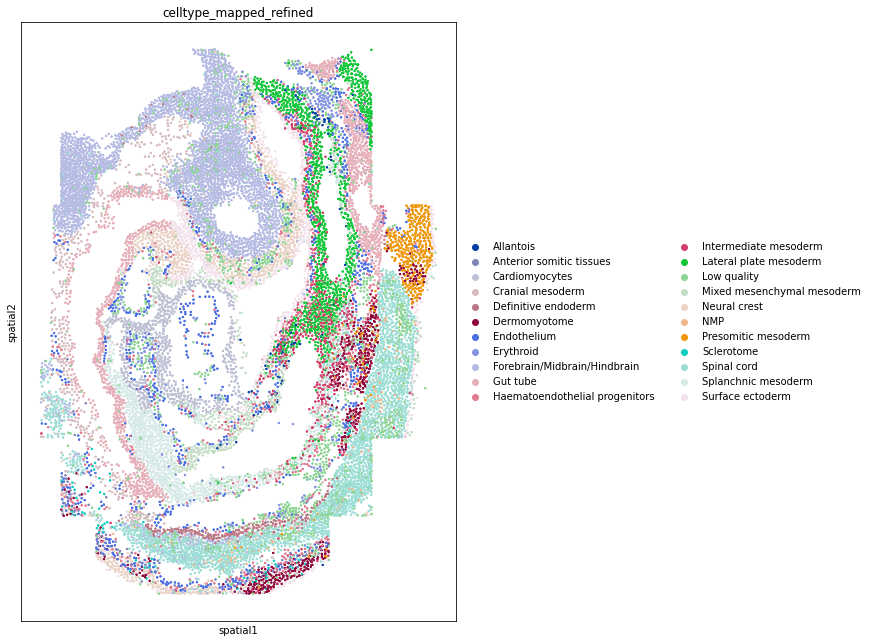

In [12]:
# Visualize annotated data in physical space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

## 3. Autotalker Model with Fully Connected Gene Programs

### 3.1 Create Fully Connected Gene Program Mask

In [13]:
# Mask that allows all genes
if node_label_method == "self":
    n_output = len(adata.var)
    gp_targets_mask = np.ones((n_latent_fc_gps, n_output))
    print(f"gp_targets_mask shape: {gp_targets_mask.shape}")
elif node_label_method != "self":
    n_output = len(adata.var) * 2
    gp_targets_mask = np.ones((n_latent_fc_gps, int(n_output / 2)))
    gp_sources_mask = np.ones((n_latent_fc_gps, int(n_output / 2)))
    print(f"gp_targets_mask shape: {gp_targets_mask.shape}.")
    print(f"gp_sources_mask shape: {gp_sources_mask.shape}.")

gp_targets_mask shape: (512, 351).
gp_sources_mask shape: (512, 351).


### 3.2 Initialize, Train & Save Model

In [14]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key=None,
                   gp_sources_mask_key=None,
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=int(n_latent_fc_gps/2),
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=gp_targets_mask,
                   gp_sources_mask=(None if node_label_method == "self" else gp_sources_mask))

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True
NODE LABEL METHOD -> one-hop-norm
GCN ENCODER -> n_input: 351, n_hidden: 256, n_latent: 512, n_addon_latent: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 512, n_addon_input: 0, n_output: 702


In [15]:
experiment = mlflow.set_experiment("autotalker_fc_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=1,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=None,
            verbose=False) #experiment.experiment_id)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of training edges: 63181
Number of validation edges: 7432
Number of test edges: 3716

--- MODEL TRAINING ---
Epoch 1/1 |████████████████████| 100.0% train_loss: 569.7569; val_loss: 561.5626

Model training finished after 2 min 21 sec.
Using best model state, which was in epoch 1.

--- MODEL EVALUATION ---
Test AUROC score: 0.9480
Test AUPRC score: 0.9354
Test best accuracy score: 0.8883
Test best F1 score: 0.8920


In [16]:
model.save(dir_path="./model_artefacts/autotalker_fc_gps",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

In [ ]:
model = Autotalker.load(dir_path="./model_artefacts/autotalker_fc_gps",
                        adata=None,
                        adata_file_name="adata.h5ad")

### 3.3. Visualize Latent Gene Programs with scanpy

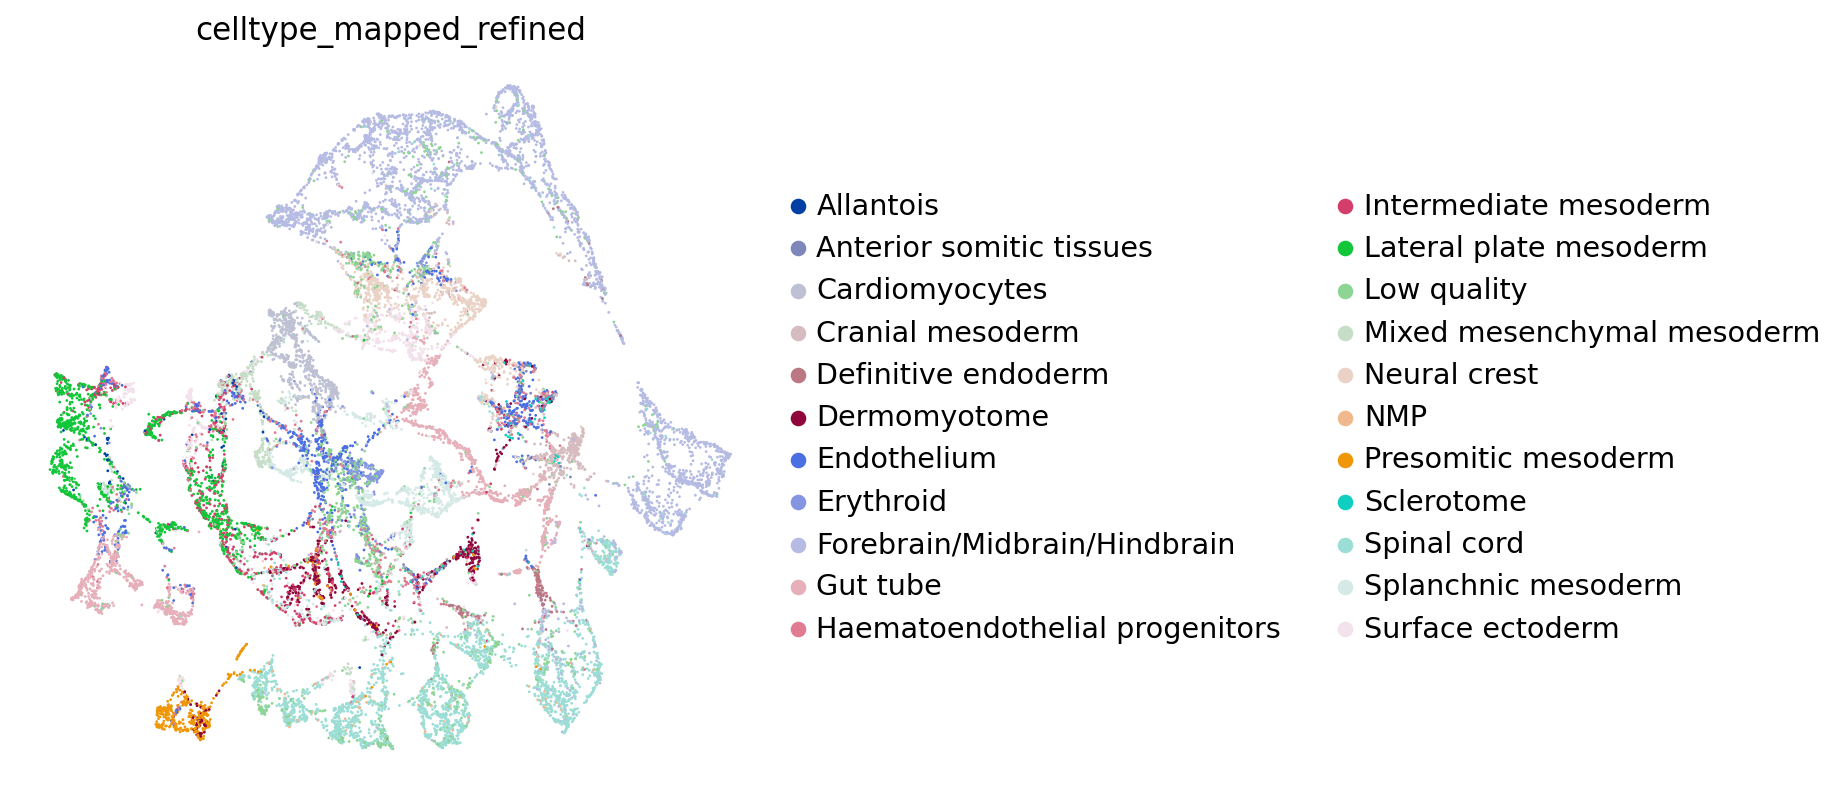

In [20]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_fc_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_fc_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_fc_gps_{current_time}.png")

## 4. Autotalker Model with Cell-Cell-Interaction (CCI) Gene Programs

### 4.1 NicheNet Ligand Target Gene CCI Gene Programs

#### 4.1.1 Create NicheNet CCI Gene Program Mask

In [ ]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.1,
    load_from_disk=False,
    save_to_disk=True,
    file_path=nichenet_ligand_target_mx_file_path)

In [ ]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=nichenet_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_nichenet_gps_targets",
    gp_sources_varm_key="autotalker_nichenet_gps_sources",
    gp_names_uns_key="autotalker_nichenet_gps_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [ ]:
print(f"Number of gene programs: {len(adata.uns['autotalker_nichenet_gps_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_nichenet_gps_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_nichenet_gps_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_nichenet_gps_sources'].sum()}.")

In [ ]:
nichenet_gps_targets_mask = torch.tensor(adata.varm["autotalker_nichenet_gps_targets"].T, dtype=torch.float32)
nichenet_gps_sources_mask = torch.tensor(adata.varm["autotalker_nichenet_gps_sources"].T, dtype=torch.float32)
nichenet_gps_mask = torch.cat((nichenet_gps_targets_mask, nichenet_gps_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {nichenet_gps_mask.shape}.")
nichenet_gps_n_hidden_encoder = int(nichenet_gps_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {nichenet_gps_n_hidden_encoder}.")

#### 4.1.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_nichenet_gps_targets",
                   gp_sources_mask_key="autotalker_nichenet_gps_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=nichenet_gps_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

In [ ]:
experiment = mlflow.set_experiment("autotalker_nichenet_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=1,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id)

In [ ]:
model.save(dir_path="./model_artefacts/autotalker_nichenet_gps",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

#### 4.1.3 Visualize Latent Gene Programs with scanpy

In [ ]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_nichenet_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_nichenet_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_nichenet_gps_{current_time}.png")

### 4.2 OmniPath Ligand Receptor CCI Gene Programs

#### 4.2.1 Create OmniPath CCI Gene Program Mask

In [41]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [42]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=omnipath_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_omnipath_gps_targets",
    gp_sources_varm_key="autotalker_omnipath_gps_sources",
    gp_names_uns_key="autotalker_omnipath_gps_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [43]:
print(f"Number of gene programs: {len(adata.uns['autotalker_omnipath_gps_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_omnipath_gps_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_omnipath_gps_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_omnipath_gps_sources'].sum()}.")

Number of gene programs: 104.
Example gene programs: ['EPOR_ligand_receptor_GP', 'KL_ligand_receptor_GP', 'TP53_ligand_receptor_GP', 'CXCL12_ligand_receptor_GP', 'NTN1_ligand_receptor_GP'].
Number of gene program target genes: 50.
Number of gene program source genes: 59.


In [44]:
omnipath_gps_targets_mask = torch.tensor(adata.varm["autotalker_omnipath_gps_targets"].T, dtype=torch.float32)
omnipath_gps_sources_mask = torch.tensor(adata.varm["autotalker_omnipath_gps_sources"].T, dtype=torch.float32)
omnipath_gps_mask = torch.cat((omnipath_gps_targets_mask, omnipath_gps_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {omnipath_gps_mask.shape}.")
omnipath_gps_n_hidden_encoder = int(omnipath_gps_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {omnipath_gps_n_hidden_encoder}.")

Gene program mask shape (gene programs x nodes): torch.Size([104, 702]).
Number of hidden layers in the encoder: 52.


#### 4.2.2 Initialize, Train & Save Model

In [45]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_omnipath_gps_targets",
                   gp_sources_mask_key="autotalker_omnipath_gps_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=omnipath_gps_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True
NODE LABEL METHOD -> one-hop-norm
GCN ENCODER -> n_input: 351, n_hidden: 52, n_latent: 104, n_addon_latent: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 104, n_addon_input: 0, n_output: 702


In [46]:
experiment = mlflow.set_experiment("autotalker_omnipath_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=1,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of training edges: 63181
Number of validation edges: 7432
Number of test edges: 3716

--- MODEL TRAINING ---
Epoch 1/1 |████████████████████| 100.0% train_loss: 838.8100; val_loss: 830.4805

Model training finished after 0 min 48 sec.
Using best model state, which was in epoch 1.

--- MODEL EVALUATION ---
Test AUROC score: 0.7988
Test AUPRC score: 0.7691
Test best accuracy score: 0.5075
Test best F1 score: 0.6700


In [47]:
model.save(dir_path="./model_artefacts/autotalker_omnipath_gps",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

#### 4.2.3 Visualize Latent Gene Programs with scanpy

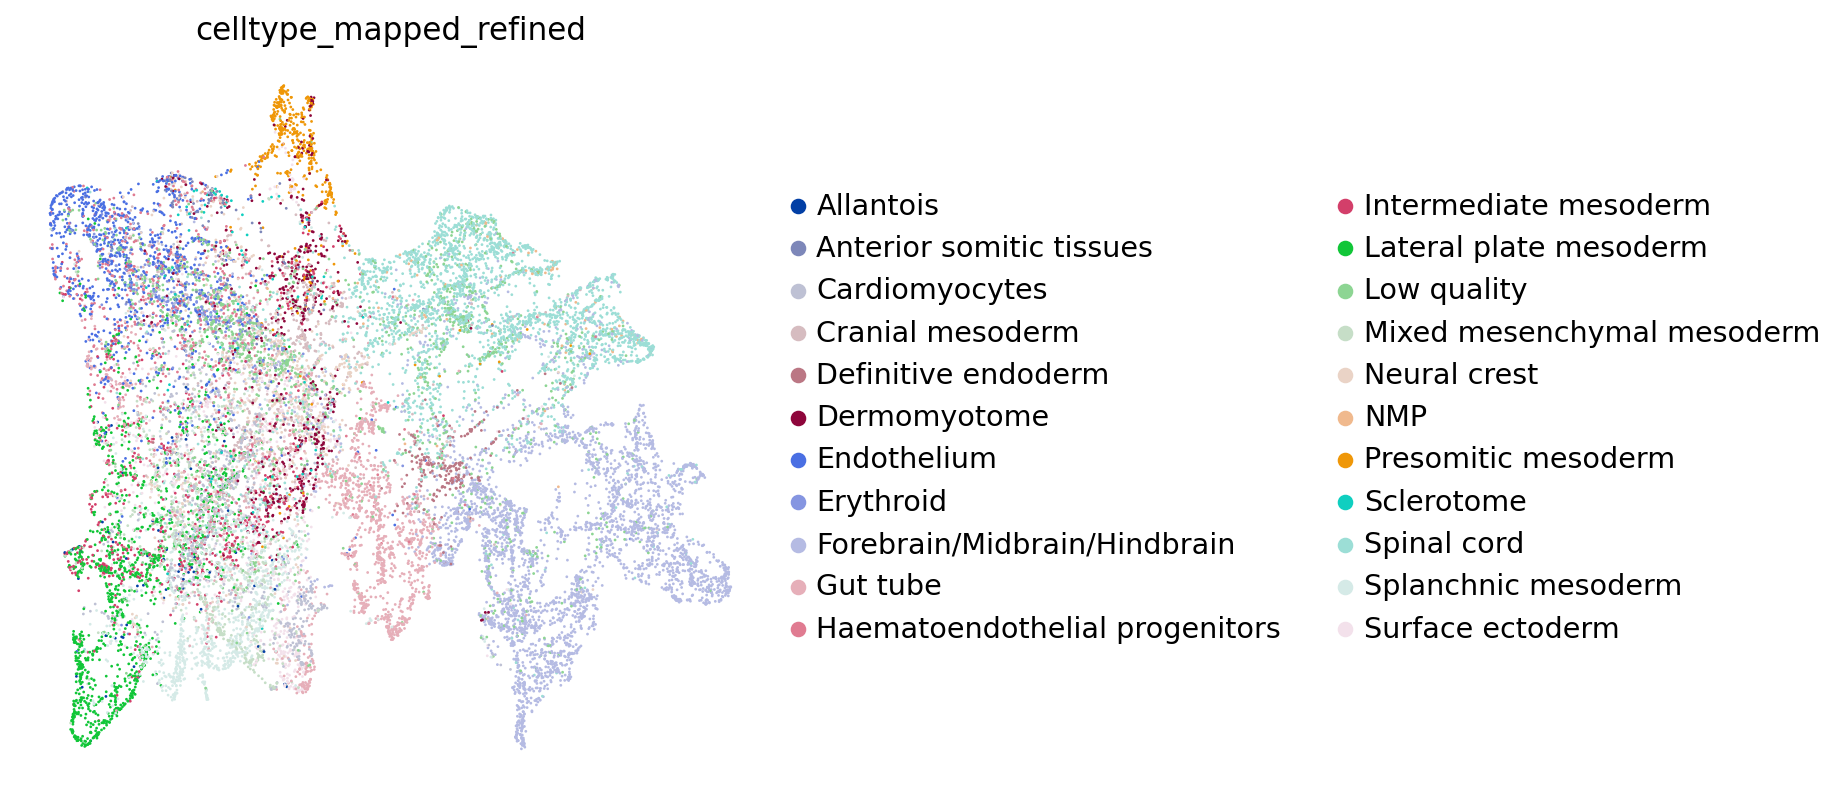

In [48]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_omnipath_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_omnipath_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_omnipath_gps_{current_time}.png")

### 4.3 Mebocost Metabolite Enzyme Sensor CCI Gene Programs

In [ ]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(species="mouse")

In [ ]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=mebocost_gp_dict,
    genes_uppercase=False,
    gp_targets_varm_key="autotalker_mebocost_gps_targets",
    gp_sources_varm_key="autotalker_mebocost_gps_sources",
    gp_names_uns_key="autotalker_mebocost_gps_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [ ]:
print(f"Number of gene programs: {len(adata.uns['autotalker_mebocost_gps_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_mebocost_gps_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_mebocost_gps_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_mebocost_gps_sources'].sum()}.")

In [ ]:
mebocost_gps_targets_mask = torch.tensor(adata.varm["autotalker_mebocost_gps_targets"].T, dtype=torch.float32)
mebocost_gps_sources_mask = torch.tensor(adata.varm["autotalker_mebocost_gps_sources"].T, dtype=torch.float32)
mebocost_gps_mask = torch.cat((mebocost_gps_targets_mask, mebocost_gps_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {mebocost_gps_mask.shape}.")
mebocost_gps_n_hidden_encoder = int(mebocost_gps_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {mebocost_gps_n_hidden_encoder}.")

#### 4.2.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_mebocost_gps_targets",
                   gp_sources_mask_key="autotalker_mebocost_gps_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=mebocost_gps_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

In [ ]:
experiment = mlflow.set_experiment("autotalker_omnipath_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=1,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id)

In [ ]:
model.save(dir_path="./model_artefacts/autotalker_mebocost_gps",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

#### 4.2.3 Visualize Latent Gene Programs with scanpy

In [ ]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_mebocost_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_mebocost_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_mebocost_gps_{current_time}.png")

### 4.4 Combined Prior Knowledge CCI Gene Programs

#### 4.4.1 Create Combined Prior Knowledge CCI Gene Program Mask

In [87]:
# Extract NicheNet ligand target gene gene programs into a dictionary
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.1,
    load_from_disk=False,
    save_to_disk=True,
    file_path=nichenet_ligand_target_mx_file_path)

In [98]:
list(nichenet_gp_dict.keys())[:5]

['CXCL1_ligand_targetgenes_GP',
 'CXCL2_ligand_targetgenes_GP',
 'CXCL3_ligand_targetgenes_GP',
 'CXCL5_ligand_targetgenes_GP',
 'PPBP_ligand_targetgenes_GP']

In [88]:
# Extract OmniPath ligand receptor gene programs into a dictionary
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [99]:
list(omnipath_gp_dict.keys())[:5]

['BDNF_ligand_receptor_GP',
 'EPOR_ligand_receptor_GP',
 'FYN_ligand_receptor_GP',
 'AVP_ligand_receptor_GP',
 'NGF_ligand_receptor_GP']

In [121]:
# Extract MEBOCOST enzyme sensor gene programs into a dictionary
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    species="mouse",
    genes_uppercase=True)

In [123]:
list(mebocost_gp_dict.keys())[:5]

['Deoxyuridine_metabolite_enzyme_sensor_GP',
 'Deoxycytidine_metabolite_enzyme_sensor_GP',
 '3-Methoxytyramine_metabolite_enzyme_sensor_GP',
 'Biotin_metabolite_enzyme_sensor_GP',
 'Androsterone_metabolite_enzyme_sensor_GP']

In [124]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [125]:
#  Add the gene program dictionary to the AnnData object
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=combined_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_combined_gp_targets",
    gp_sources_varm_key="autotalker_combined_gp_sources",
    gp_names_uns_key="autotalker_combined_gp_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [148]:
# Print gene program info
print(f"Number of gene programs: {len(adata.uns['autotalker_combined_gp_names'])}.")
print(f"Example gene programs: {random.sample(adata.uns['autotalker_combined_gp_names'], 5)}.")
print(f"Number of total gene program target genes: {adata.varm['autotalker_combined_gp_targets'].sum()}.")
print(f"Number of total gene program source genes: {adata.varm['autotalker_combined_gp_sources'].sum()}.")

Number of gene programs: 802.
Example gene programs: ['DLL4_ligand_targetgenes_GP', 'OSGIN1_ligand_targetgenes_GP', 'CCL4_ligand_targetgenes_GP', 'IL13_ligand_targetgenes_GP', 'LAMB2_ligand_targetgenes_GP'].
Number of total gene program target genes: 68295.
Number of total gene program source genes: 135.


In [149]:
# Create gene program mask
combined_gp_targets_mask = torch.tensor(adata.varm["autotalker_combined_gp_targets"].T, dtype=torch.float32)
combined_gp_sources_mask = torch.tensor(adata.varm["autotalker_combined_gp_sources"].T, dtype=torch.float32)
combined_gp_mask = torch.cat((combined_gp_targets_mask, combined_gp_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {combined_gp_mask.shape}.")
combined_gp_n_hidden_encoder = int(combined_gp_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {combined_gp_n_hidden_encoder}.")

Gene program mask shape (gene programs x nodes): torch.Size([802, 702]).
Number of hidden layers in the encoder: 401.


#### 4.4.2 Initialize, Train & Save Model

In [151]:
# Pass masks either trough ´gp_targets_mask_key´ and ´gp_sources_mask_key´ of adata or directly
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_combined_gp_targets",
                   gp_sources_mask_key="autotalker_combined_gp_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=combined_gp_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True
NODE LABEL METHOD -> one-hop-norm
GCN ENCODER -> n_input: 351, n_hidden: 401, n_latent: 802, n_addon_latent: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 802, n_addon_input: 0, n_output: 702


In [152]:
experiment = mlflow.set_experiment("autotalker_combined_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=1,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=32,
            grad_clip_value=5,
            mlflow_experiment_id=experiment.experiment_id)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of training edges: 63181
Number of validation edges: 7432
Number of test edges: 3716

--- MODEL TRAINING ---
Epoch 1/1 |████████████████████| 100.0% train_loss: 755.6308; val_loss: 745.2571

Model training finished after 3 min 35 sec.
Using best model state, which was in epoch 1.

--- MODEL EVALUATION ---
Test AUROC score: 0.8711
Test AUPRC score: 0.7967
Test best accuracy score: 0.5444
Test best F1 score: 0.6870


In [153]:
model.save(dir_path="./model_artefacts/autotalker_combined_gps",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

#### 4.4.3 Visualize Latent Gene Programs

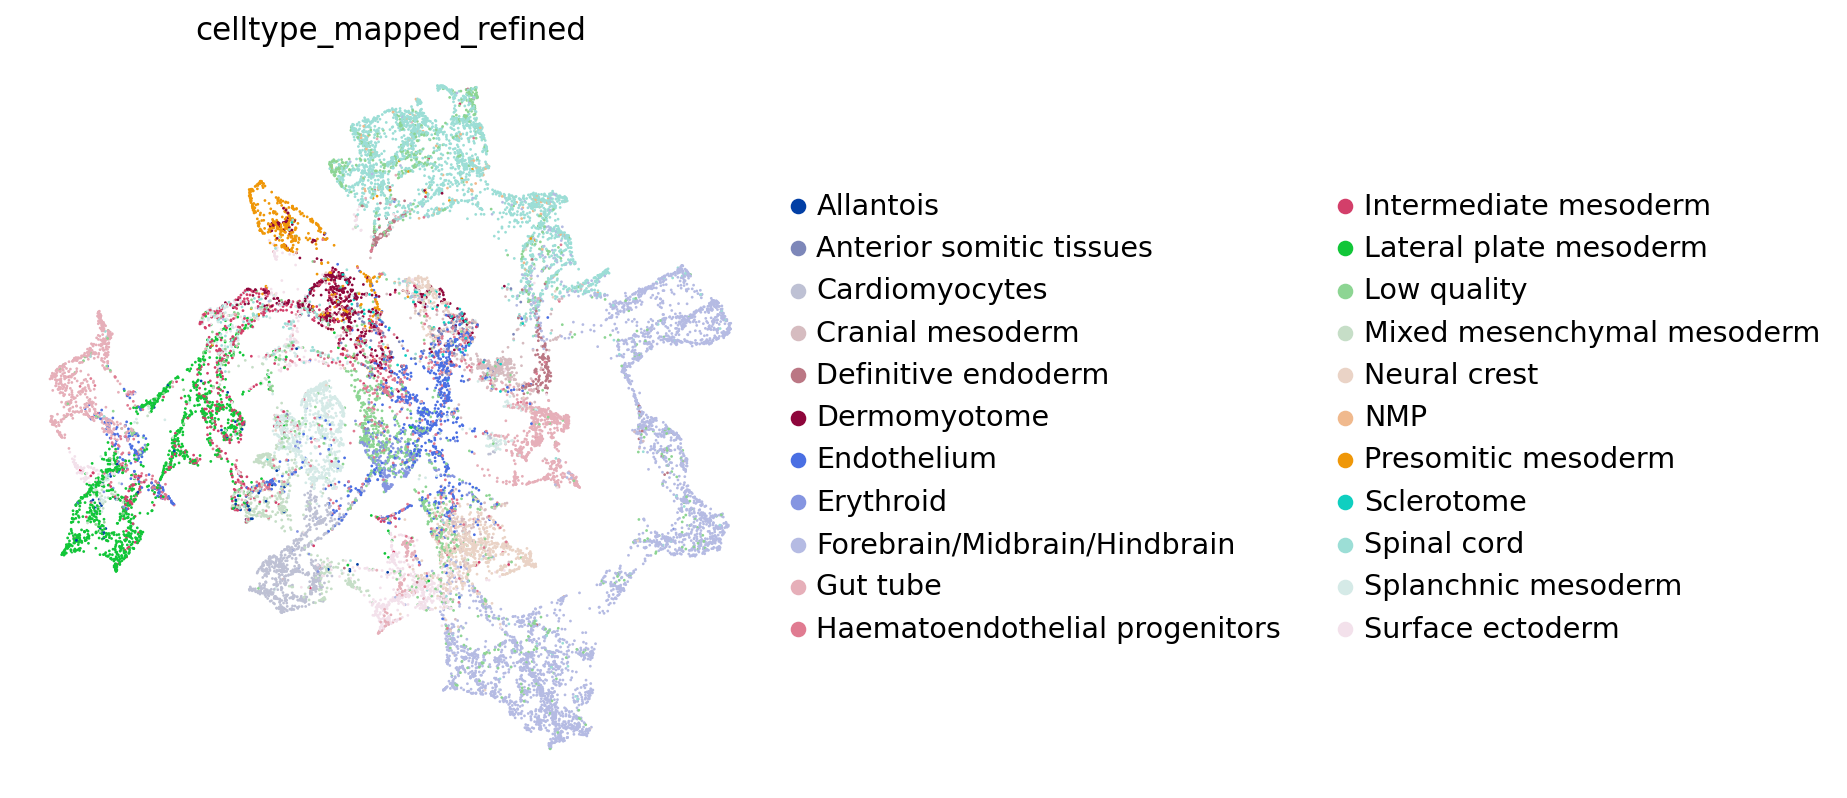

In [154]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["autotalker_combined_gp_latent"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="autotalker_combined_gp_latent")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_autotalker_combined_gp_latent_{current_time}.png")

The model can maintain the edge reconstruction performance while tweaking the latent space for better gene expression reconstruction.

In [ ]:
gene_programs = adata.uns["autotalker_combined_gps_names"]

In [ ]:
gene_programs = adata.uns["autotalker_combined_gps_names"]
selected_gene_programs = ["CSF1_ligand_targetgenes_GP", "IL34_ligand_targetgenes_GP"]
selected_gene_programs_idx = [gene_programs.index(gene_program) for gene_program in selected_gene_programs]

In [ ]:
latent_selected_gps = latent[:, selected_gene_programs_idx]

In [ ]:
adata.obs["CSF1_ligand_targetgenes_GP"] = latent_selected_gps[:, 0]
adata.obs["IL34_ligand_targetgenes_GP"] = latent_selected_gps[:, 1]

In [ ]:
sc.pl.umap(adata, color="CSF1_ligand_targetgenes_GP", frameon=False, wspace=0.6)

In [ ]:
sc.pl.scatter(adata, x="CSF1_ligand_targetgenes_GP", y="IL34_ligand_targetgenes_GP", color=cell_type_key, size=10)

### 4.5 Learn New CCI Gene Programs

In [ ]:
model = Autotalker.load(dir_path="./model_artefacts/autotalker_nichenet_gps",
                        adata=None,
                        adata_file_name="adata.h5ad",
                        n_addon_gps=10,
                        freeze_non_addon_weights=True)

In [ ]:
model.train(n_epochs=1,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=None,
            verbose=True) #experiment.experiment_id)

In [ ]:
model.save(dir_path="./model_artefacts/autotalker_fc_gps",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

### 5. Benchmarking

#### Graph Connectivity Distance (GCD)

Measures the edge preservation in the latent space vs the physical space.

In [ ]:
avg_gcd = compute_avg_gcd(adata=adata,
                          spatial_key="spatial",
                          latent_key="latent_autotalker_fc_gps",
                          seed=random_state)
print("Average graph connectivity distance:", avg_gcd)

#### Leiden Normalized Mutual Info (LNMI)

Measures the preservation of spatial organization by comparing cluster overlaps between the latent space and physical space.

In [ ]:
max_lnmi = compute_max_lnmi(adata=adata,
                            spatial_key="spatial",
                            latent_key="latent_autotalker_fc_gps",
                            seed=random_state,
                            visualize_leiden_clustering=True)
print(f"Maximum Leiden Normalized Mutual Info: {max_lnmi}.")

#### Cell-type Affinity Distance (CAD)

Measures preservation of cell-cell contact maps, that means cell-type enrichments in a cell’s neighborhood across all cells, in latent space vs physical space.

In [ ]:
avg_cad = compute_avg_cad(adata=adata,
                          cell_type_key=cell_type_key,
                          spatial_key="spatial",
                          latent_key="latent_autotalker_fc_gps",
                          seed=random_state)
print("Average cell-type affinity distance:", avg_cad)

In [ ]:
cad = compute_cad(adata=adata,
                  cell_type_key=cell_type_key,
                  spatial_key="spatial",
                  latent_key="latent_autotalker_fc_gps",
                  n_neighbors=15,
                  seed=random_state,
                  visualize_ccc_maps=True)
print("Cell-type affinity distance:", cad)

#### Relative Cell-type Local Inverse Simpson's Index (RCLISI)

Measures preservation of spatial cell-type heterogeneity in latent space vs physical space.

In [ ]:
per_cell_log_rclisi_df = compute_per_cell_log_rclisi(adata=adata,
                                                     cell_type_key=cell_type_key,
                                                     spatial_key="spatial",
                                                     latent_key="latent_autotalker_fc_gps",
                                                     n_neighbors=15,
                                                     seed=random_state)

In [ ]:
sns.displot(per_cell_log_rclisi_df, x="log_rclisi", kind="kde", bw_adjust=2, height=3, aspect=10)

#### Gene Expression Reconstruction (GER)

### 6. Analysis

#### 6.1 Compute Latent Graph Connectivities 

In [164]:
latent_key = "autotalker_combined_gp_latent"
gp_key = "autotalker_combined_gp_names"

In [165]:
model.compute_latent_graph_connectivities(adata=None,
                                          latent_key=latent_key,
                                          n_neighbors=15,
                                          mode="knn",
                                          seed=42)

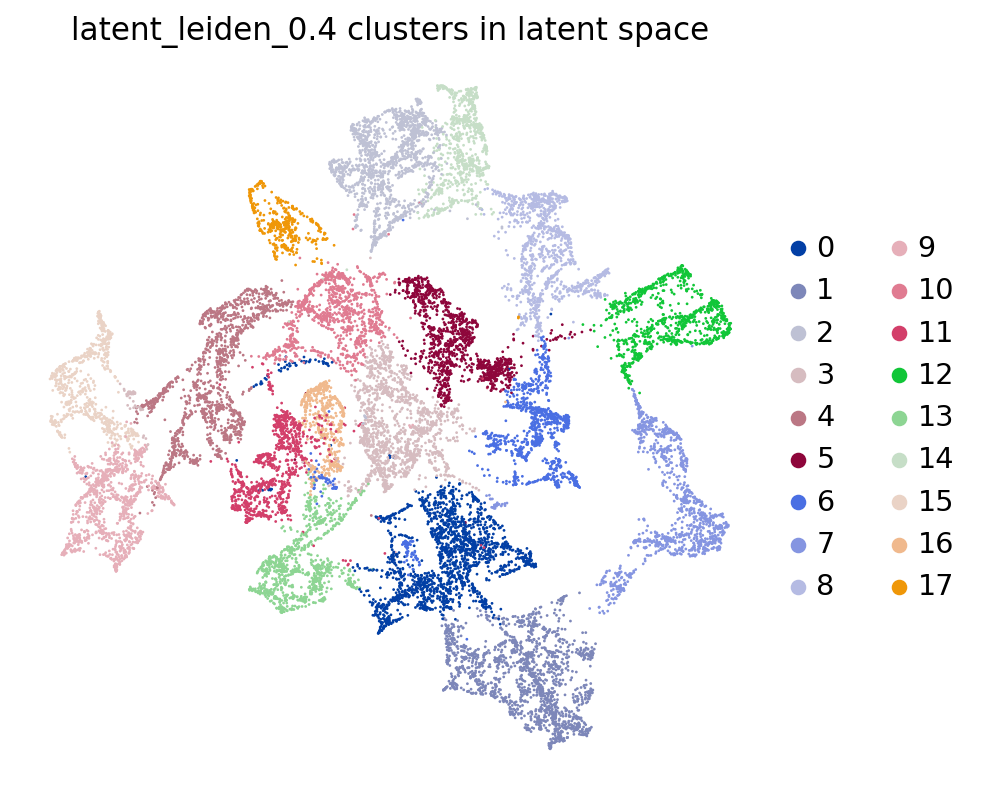

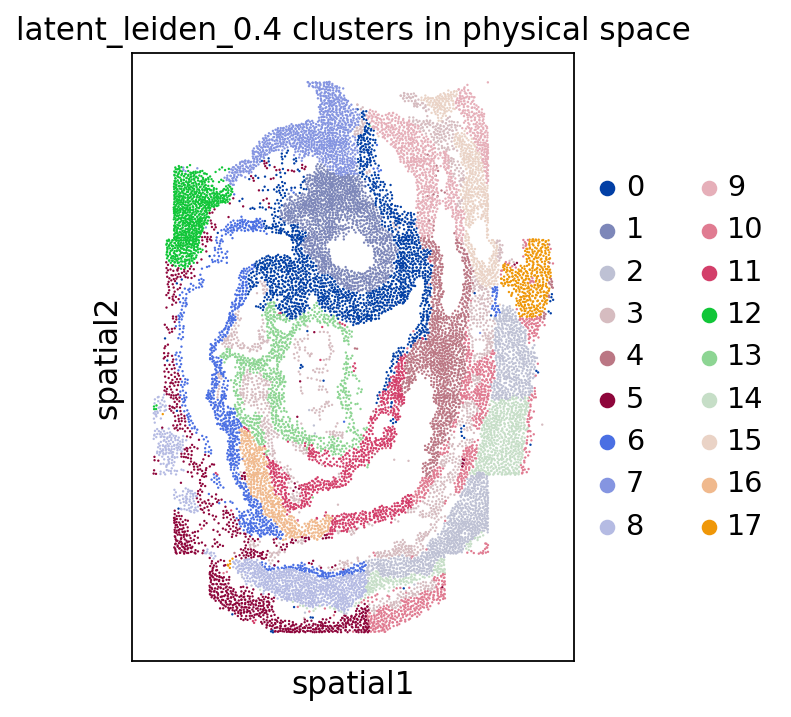

In [166]:
# Compute latent Leiden clustering
resolution = 0.4

sc.tl.leiden(adata=adata,
             resolution=resolution,
             random_state=random_state,
             key_added=f"latent_leiden_{str(resolution)}",
             adjacency=adata.obsp["latent_connectivities"])

# Visualize latent Leiden clusters in latent space
sc.pp.neighbors(adata=adata, use_rep=latent_key)
sc.tl.umap(adata=adata, min_dist=0.3)
sc.pl.umap(adata=adata,
           color=[f"latent_leiden_{str(resolution)}"],
           frameon=False,
           title=f"latent_leiden_{str(resolution)} clusters in latent space")

# Visualize latent Leiden clusters in physical space
with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.spatial(adata=adata,
                  color=[f"latent_leiden_{str(resolution)}"],
                  ncols=5,
                  spot_size=0.03,
                  title=f"latent_leiden_{str(resolution)} clusters in physical space")

#### 6.1 Gene Program Enrichment Scores

##### 6.1.1 Cell-type Gene Program Enrichment Scores

In [169]:
model.calculate_gp_enrichment_scores(cat_key=cell_type_key,
                                     gp_key=gp_key,
                                     adata=adata,
                                     comparison_cats="rest",
                                     selected_gps=["WNT2B_ligand_receptor_GP", "PECAM1_ligand_receptor_GP"],
                                     n_sample=1000,
                                     key_added="autotalker_combined_gp_cell_type_gp_enrichment_scores")

In [170]:
adata.uns["autotalker_combined_gp_cell_type_gp_enrichment_scores"].head()

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,Endothelium,WNT2B_ligand_receptor_GP,0.743308,0.256692,1.063234
1,Splanchnic mesoderm,PECAM1_ligand_receptor_GP,0.723437,0.276563,0.961576
2,Gut tube,PECAM1_ligand_receptor_GP,0.711795,0.288205,0.904116
3,Anterior somitic tissues,WNT2B_ligand_receptor_GP,0.681223,0.318777,0.759399
4,Sclerotome,WNT2B_ligand_receptor_GP,0.617991,0.382009,0.481031


##### 6.1.2 Spatial Gene Program Enrichment Scores

In [171]:
model.calculate_gp_enrichment_scores(cat_key=f"latent_leiden_{str(resolution)}",
                                     gp_key=gp_key,
                                     adata=adata,
                                     comparison_cats="rest",
                                     selected_gps=["WNT2B_ligand_receptor_GP", "PECAM1_ligand_receptor_GP"],
                                     n_sample=1000,
                                     key_added="autotalker_combined_gp_cell_type_gp_enrichment_scores")

In [172]:
adata.uns["autotalker_combined_gp_cell_type_gp_enrichment_scores"].head()

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,12,WNT2B_ligand_receptor_GP,0.880723,0.119277,1.999299
1,16,PECAM1_ligand_receptor_GP,0.836305,0.163695,1.630987
2,8,WNT2B_ligand_receptor_GP,0.773092,0.226908,1.225853
3,7,WNT2B_ligand_receptor_GP,0.735495,0.264505,1.022683
4,8,PECAM1_ligand_receptor_GP,0.734761,0.265239,1.018915


#### 6.3 Gene Program Gene Importances

In [173]:
model.compute_gp_gene_importances(gp_name="WNT2B_ligand_receptor_GP",
                                  gp_key=gp_key)

,gene,gene_entity,weights_nb_means_normalized,weights_zi_prob_logits,weight_based_importance
0,Col1a2,target,0.184637,0.140686,0.022460
1,Shh,target,0.090777,-0.290137,0.018555
2,Fxyd2,target,0.101676,0.229416,0.017534
3,Pdgfa,target,0.140312,0.108538,0.017123
4,Pax8,target,0.156053,0.058151,0.016917
...,...,...,...,...,...
223,Nodal,target,0.007384,-0.015283,0.001226
224,Pou3f1,target,-0.009883,-0.004520,0.001100
225,Sfmbt2,target,-0.002672,0.023289,0.001048
226,Tmem37,target,-0.004496,0.017229,0.001016


In [174]:
adata.uns["autotalker_combined_gp_cell_type_gp_enrichment_scores"]

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,12,WNT2B_ligand_receptor_GP,0.880723,0.119277,1.999299
1,16,PECAM1_ligand_receptor_GP,0.836305,0.163695,1.630987
2,8,WNT2B_ligand_receptor_GP,0.773092,0.226908,1.225853
3,7,WNT2B_ligand_receptor_GP,0.735495,0.264505,1.022683
4,8,PECAM1_ligand_receptor_GP,0.734761,0.265239,1.018915
5,6,PECAM1_ligand_receptor_GP,0.716746,0.283254,0.928378
6,5,WNT2B_ligand_receptor_GP,0.675229,0.324771,0.731933
7,15,PECAM1_ligand_receptor_GP,0.640177,0.359823,0.576133
8,17,WNT2B_ligand_receptor_GP,0.595099,0.404901,0.385085
9,16,WNT2B_ligand_receptor_GP,0.587114,0.412886,0.352046
